# 1D Finite Element Solver
We aim to solve a differential equation for a 1 dimensional case with the form
$$
- \frac{\partial}{\partial x} \alpha(x) \cdot \frac{\partial \Phi (x)}{\partial x} + \beta(x) \cdot \Phi (x)=f (x)
$$
with the galerkin method. Details can be found in the [lecture notes]("G:\My Drive\HKA EITB\Semester 6\Methoden der Feldberechnung\GalerkinVerfahren.pdf"), page 13.

To do so, we split the domain of the function given as boundary values in smaller parts and solve a linear equations system comprising all elements.

## Initialise the Exercise Information

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

import functions as myfunc

In [11]:
def alpha(x):
    """
    Piecewise function for alpha(x):
    - 3 in [1.5, 2.7]
    - x^2 elsewhere
    """
    x = np.asarray(x)
    return np.where((1.5 <= x) & (x <= 2.7), 3.0, np.square(x))

def beta(x):
    """
    Piecewise function for beta(x):
    - x / (x+1) in [1, 2]
    - x^2 elsewhere
    """
    x = np.asarray(x)
    return np.where((1 <= x) & (x <= 2), x / (x + 1), np.square(x))

def rhs(x):
    """
    Right-hand side f(x):
    - x in [2, 4]
    - x + 1 elsewhere
    """
    x = np.asarray(x)
    return np.where((2 <= x) & (x <= 4), x, x + 1)

In [12]:
DOMAIN_BOUNDARY = {
    "Lower Bound": 1,
    "Upper Bound": 4
}
BOUNDARY_CONDITION = {
    "Lower Bound": {
        "x": DOMAIN_BOUNDARY["Lower Bound"],
        "Phi": np.exp(DOMAIN_BOUNDARY["Lower Bound"])
    },
    "Upper Bound": {
        "x": DOMAIN_BOUNDARY["Upper Bound"],
        "Phi": np.exp(DOMAIN_BOUNDARY["Upper Bound"])
    }
}

## Define Elements

In [13]:
NUMBER_OF_NODES = 10000

element_nodes = np.linspace(DOMAIN_BOUNDARY["Lower Bound"], DOMAIN_BOUNDARY["Upper Bound"], num=NUMBER_OF_NODES)
print(element_nodes)

element_indices = myfunc.get_edge_indices(element_nodes)
print(element_indices)

# Append boundary dict with index position of x value
BOUNDARY_CONDITION["Lower Bound"]["x Index"] = np.where(np.isclose(element_nodes, BOUNDARY_CONDITION["Lower Bound"]["x"]))[0][0]
BOUNDARY_CONDITION["Upper Bound"]["x Index"] =np.where(np.isclose(element_nodes, BOUNDARY_CONDITION["Upper Bound"]["x"]))[0][0]
print(BOUNDARY_CONDITION)

[1.         1.00030003 1.00060006 ... 3.99939994 3.99969997 4.        ]
[[   0    1]
 [   1    2]
 [   2    3]
 ...
 [9996 9997]
 [9997 9998]
 [9998 9999]]
{'Lower Bound': {'x': 1, 'Phi': np.float64(2.718281828459045), 'x Index': np.int64(0)}, 'Upper Bound': {'x': 4, 'Phi': np.float64(54.598150033144236), 'x Index': np.int64(9999)}}


## Create Domain Matrix by generating matrix values for each element

In [14]:
elements = []
for indices in element_indices:
    element = myfunc.assemble_element(element_nodes, indices[0], indices[1], alpha, beta, rhs)
    elements.append(element)

print(elements)

[{'Start Index': np.int64(0), 'End Index': np.int64(1), 'Coefficients': array([[ 3334.00012502, -3334.00005   ],
       [-3334.00005   ,  3334.00012502]]), 'Right Hand Side': array([0.00030005, 0.00030005])}, {'Start Index': np.int64(1), 'End Index': np.int64(2), 'Coefficients': array([[ 3336.00072508, -3336.00065006],
       [-3336.00065006,  3336.00072508]]), 'Right Hand Side': array([0.0003001, 0.0003001])}, {'Start Index': np.int64(2), 'End Index': np.int64(3), 'Coefficients': array([[ 3338.00192521, -3338.00185018],
       [-3338.00185018,  3338.00192521]]), 'Right Hand Side': array([0.00030014, 0.00030014])}, {'Start Index': np.int64(3), 'End Index': np.int64(4), 'Coefficients': array([[ 3340.0037254 , -3340.00365035],
       [-3340.00365035,  3340.0037254 ]]), 'Right Hand Side': array([0.00030019, 0.00030019])}, {'Start Index': np.int64(4), 'End Index': np.int64(5), 'Coefficients': array([[ 3342.00612564, -3342.00605059],
       [-3342.00605059,  3342.00612564]]), 'Right Hand Si

In [15]:
coefficients_matrix, rhs_matrix = myfunc.create_global_les(elements)

print(coefficients_matrix)
print(rhs_matrix)

[[  3334.00012502  -3334.00005         0.         ...      0.
       0.              0.        ]
 [ -3334.00005      6670.0008501   -3336.00065006 ...      0.
       0.              0.        ]
 [     0.          -3336.00065006   6674.0026503  ...      0.
       0.              0.        ]
 ...
 [     0.              0.              0.         ... 106624.00574962
  -53315.99987517      0.        ]
 [     0.              0.              0.         ... -53315.99987517
  106640.00394992 -53323.99927499]
 [     0.              0.              0.         ...      0.
  -53323.99927499  53324.00167505]]
[[0.00030005]
 [0.00060015]
 [0.00060024]
 ...
 [0.00119994]
 [0.00120003]
 [0.00060004]]


In [16]:
solution = myfunc.solve_leq(coefficients_matrix, rhs_matrix, NUMBER_OF_NODES, BOUNDARY_CONDITION)
print(solution)

[[ 2.71828183]
 [ 2.72391061]
 [ 2.72953595]
 ...
 [54.57400862]
 [54.58607778]
 [54.59815003]]


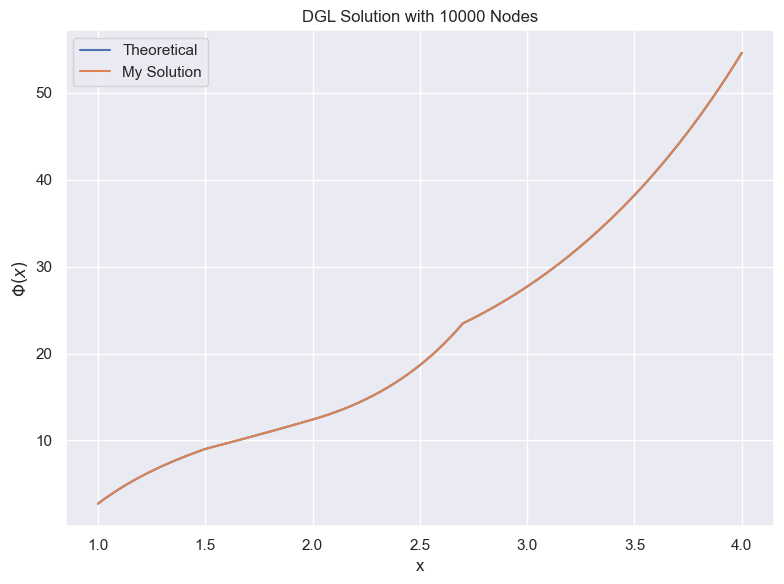

In [17]:
solution_df = myfunc.create_solution_df(element_nodes, solution)

theoretical_solution = np.loadtxt("Lösung/Netz1D_LoesungA.dat")
theoretical_nodes = np.loadtxt("Lösung/Netz1D_p.dat")
theoretical_df = myfunc.create_solution_df(theoretical_nodes, theoretical_solution)

plt.figure(figsize=(8, 6))
plt.plot(theoretical_df["x"], theoretical_df["Phi"], label="Theoretical")
plt.plot(solution_df["x"], solution_df["Phi"], label="My Solution")

plt.xlabel("x")
plt.ylabel(r"$\Phi (x)$")
plt.title(f"DGL Solution with {NUMBER_OF_NODES} Nodes")
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# plt.plot(solution_df["x"], solution_df["Phi"]-theoretical_df["Phi"])
# plt.xlabel("x")
# plt.ylabel("Error")
# plt.title("Error between my solution and theoretical")

# plt.show()